# 映像(画像)品質評価に関する調査 第1回 MSE/PSNR

映像品質を評価する際に、SSIMやPSNRが広く利用されています。
今回は最も古典的でシンプルなPSNRの理論とその問題点を解説します。

## デジタル画像の基礎知識

MSE/PSNR や SSIM はどちらも映像の品質に特化した指標ではなく、どちらも画像の品質劣化を表す指標です。
映像に応用する際には、2つの動画のフレーム画像を取り出して比較していきます。
そのためまずは画像の品質評価指標として MSE/PSNR について解説します。

しかしPSNRについて勉強する際には、ディジタル画像がどのように表現されているかを知っておく必要があります。

## グレイスケール画像の表現

In [1]:
rgb_img = Image.open(path.join(image_dir, "lena.png"))
rgb_img.thumbnail((256, 256), Image.ANTIALIAS)
rgb_array = np.asarray(rgb_img)

grayscale_img = rgb_img.convert('L')
grayscale_array = np.asarray(grayscale_img)

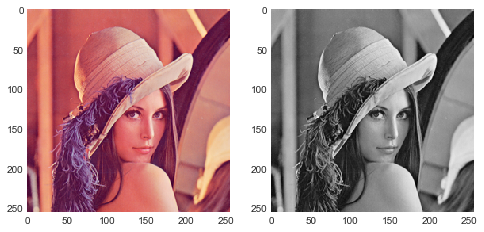

In [2]:
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax1.imshow(rgb_array)
ax2.imshow(grayscale_array, cmap='gray')
plt.show()

ここに 256pixel✕256pixel のカラー画像とグレースケール画像を用意しました。
まずはシンプルにするため、グレースケール画像をベースに画像の表現について解説します。

In [3]:
grayscale_array

array([[162, 161, 159, ..., 170, 170, 141],
       [162, 162, 159, ..., 172, 174, 147],
       [163, 160, 159, ..., 161, 151, 115],
       ...,
       [ 50,  51,  52, ...,  82,  92,  92],
       [ 45,  49,  50, ...,  93, 101,  98],
       [ 44,  52,  50, ..., 100, 103, 106]], dtype=uint8)

中身を見ると256x256の2次元配列で構成されていて、中には各ピクセルの明るさ(輝度: Luminance) が保持されています。
この明るさを高さ方向(Z座標)へマッピングすると次のようになります。

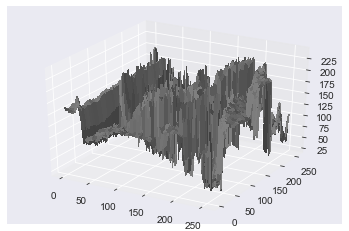

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(0, 256, 1)
Y = np.arange(0, 256, 1)
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X, Y, grayscale_array, linewidth=0, antialiased=False, color='gray')
plt.show()

こうすると画像は波のように見えますが、この「画像 = 波」という考えはあらゆるディジタル画像処理の根幹をなす重要な考え方です。
波である特性が、画像の加工や圧縮に関する理論で活用されています。PSNRの計算ではあまり波の性質を利用しませんが、今後紹介するSSIM(Multi-Scale SSIM)でもこの「波」としての特性を利用した計算が出てくるので覚えておいてください。

## MSE/PSNR による品質評価

In [5]:
grayscale_blockiness_img = grayscale_img.resize([x // 3 for x in grayscale_img.size]).resize(grayscale_img.size)
grayscale_blockiness_array = np.asarray(grayscale_blockiness_img)

grayscale_blur_img = grayscale_img.filter(ImageFilter.GaussianBlur(3))
grayscale_blur_array = np.asarray(grayscale_blur_img)

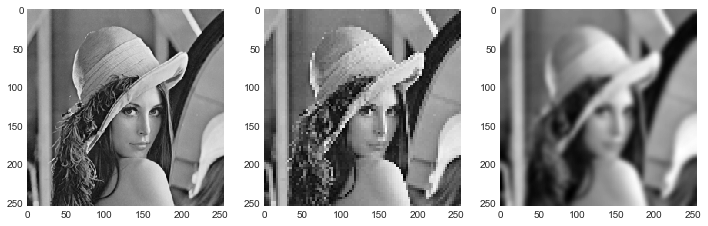

In [6]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)

ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])
ax1.imshow(grayscale_array, cmap='gray')
ax2.imshow(grayscale_blockiness_array, cmap='gray')
ax3.imshow(grayscale_blur_array, cmap='gray')
plt.show()

ブロック状のノイズで歪ませた画像と、ガウシアンブラーでぼやけた画像を用意しました。
画像の品質としては、人間の目からみても明らかに劣化していますが、どれくらい下がっているのか定量化した指標があると便利です。


PSNR(Peak signal-to-noise ratio: ピーク信号対ノイズ比) は、古くから利用されてきた指標です。
計算にはMSE(Mean Squared Error: 平均二乗誤差)を用いて、次式より求まります。


$MSE = \frac{1}{n} \Sigma^{n}_{i=1} (Y_i - \hat{Y_i} )^2$

$PSNR = 10 \times \log_{10} \frac{MAX_I^2}{MSE} = 20 \times \log_{10} \frac{MAX_I}{\sqrt{MSE}}$

In [7]:
def mse(ref, dis):
    assert ref.shape == dis.shape, "Input images must have the same dimensions."
    d = ref.astype(np.float64) - dis.astype(np.float64)
    return np.mean(d **2)

print(f"元画像のMSEスコア {mse(grayscale_array, grayscale_array):.03f}")
print(f"ブロックノイズ画像のMSEスコア {mse(grayscale_array, grayscale_blockiness_array):.03f}")
print(f"ガウシアンブラー画像のMSEスコア {mse(grayscale_array, grayscale_blur_array):.03f}")

元画像のMSEスコア 0.000
ブロックノイズ画像のMSEスコア 245.287
ガウシアンブラー画像のMSEスコア 312.883


同じ画像を入力するとMSEのスコアは 0 になります。そのため同じ画像のPSNRスコアは、「定義不可」となります。
PSNRの計算をしてみましょう。

In [8]:
def psnr(ref, dis):
    assert ref.shape == dis.shape, "Input images must have the same dimensions."
    pixel_max = 255
    return 20 * math.log10(pixel_max / math.sqrt(mse(ref, dis)))

print(f"ブロックノイズ画像のPSNRスコア {psnr(grayscale_array, grayscale_blockiness_array):.03f}")
print(f"ガウシアンブラー画像のPSNRスコア {psnr(grayscale_array, grayscale_blur_array):.03f}")

ブロックノイズ画像のPSNRスコア 24.234
ガウシアンブラー画像のPSNRスコア 23.177


PSNRのスコアは数値が大きいほど、画像の変化が小さいことを表しています。PSNRはMSEの値をただ別の尺度に変換しているだけで本質的には何も変わっていないように見えます。それにもかかわらず多くの文献が品質評価指標としてMSEではなくPSNRの方を利用しているのではどうしてでしょうか。

この理由はPeak Signalとの比で表現されることから、画像信号のダイナミックレンジに依存しないことが理由ではないかと思います。
今回あつかったデータは1つのピクセルあたり白黒の強さは 0-255 の 8 bitsで表現されていました (これは一般的に8ビットカラーとよばれるようです)。
しかしより精細に表現するためには色深度(1ピクセルが表現できる色数)を増やす必要があり、そうなると当然Peak Signalの値が変化します。
Peak Signalが変わるとその広がりに応じてMSEの値は大きく変化しますが、PSNRはPeak Signalによりある程度正規化され色深度の違うコンテンツの劣化比較でもおおよそ同じように比較することができるでしょう。　

## カラー画像の表現方法(RGBとYUV)

次はカラー画像の表現について見ていきましょう。グレースケール画像は各ピクセルの明るさだけで表現されていましたが、色を表現するにはもう少し情報が必要です。
色の表現で最も基本的なものは、みなさんもご存知の通りRGBによる表現です。
(X, Y) = (0, 0) のピクセルの中身を確認してみます。

In [9]:
rgb_array[0][0]

array([226, 137, 126], dtype=uint8)

グレースケール画像とはことなり、3つの値(RGB)を持っていることが確認できます。
そのためRGBの各成分が「波」としての特性を持っています。

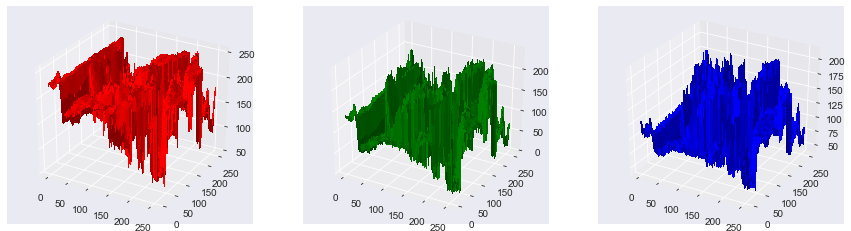

In [10]:
r_array, g_array, b_array = rgb_array[:, :, 0], rgb_array[:, :, 1], rgb_array[:, :, 2]

fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 3)

ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2], projection='3d')

ax1.plot_surface(X, Y, r_array, linewidth=0, antialiased=False, color='r')
ax2.plot_surface(X, Y, g_array, linewidth=0, antialiased=False, color='g')
ax3.plot_surface(X, Y, b_array, linewidth=0, antialiased=False, color='b')
plt.show()

また色はRGBによる表現だけでなく、 [YUV(またはYCbCr)](https://ja.wikipedia.org/wiki/YUV) と呼ばれる表現方法もあります。

* Y: 輝度信号とよばれる。人間の目が「明るさ」として感じる強さとほぼ比例した数値。
* U: Cb(Chroma Blue)ともよばれる。青の色差を示す
* V: Cr(Chroma Red) ともよばれる。赤の色差を示す。

人の目が輝度の変化には敏感なものの、色差の変化に関する識別が苦手です。なことから、色成分のサンプリング間隔を少なくします。
本来であれば1ピクセルごとにY、U、Vの値を持っていますが、人間の目が苦手な色差成分は少し減らして画像サイズを削減します。
例えば、水平2ピクセルで1つだけUとVの値を持つようなフォーマットを、「YUV422」といい間引き方に寄ってさまざまなフォーマットがあります。

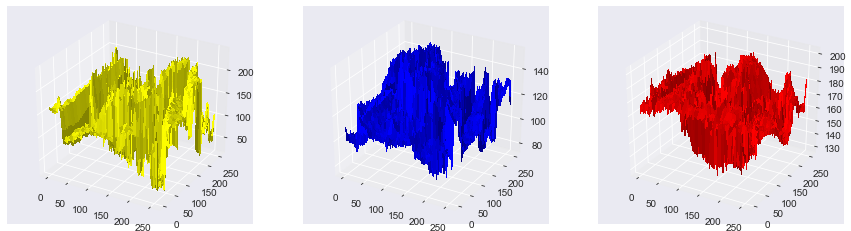

In [11]:
yuv_img = rgb_img.convert('YCbCr')
yuv_array = np.asarray(yuv_img)
y_array, u_array, v_array = yuv_array[:, :, 0], yuv_array[:, :, 1], yuv_array[:, :, 2]

fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 3)

ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2], projection='3d')

ax1.plot_surface(X, Y, y_array, linewidth=0, antialiased=False, color='yellow')
ax2.plot_surface(X, Y, u_array, linewidth=0, antialiased=False, color='b')
ax3.plot_surface(X, Y, v_array, linewidth=0, antialiased=False, color='r')
plt.show()

## カラー画像における MSE/PSNR の計算

In [12]:
yuv_blockiness_img = yuv_img.resize([x // 3 for x in yuv_img.size]).resize(yuv_img.size)
rgb_blockiness_img = yuv_blockiness_img.convert("RGB")
yuv_blockiness_array = np.asarray(yuv_blockiness_img)

rgb_blur_img = rgb_img.filter(ImageFilter.GaussianBlur(3.0))
yuv_blur_img = rgb_blur_img.convert('YCbCr')
yuv_blur_array = np.asarray(yuv_blur_img)

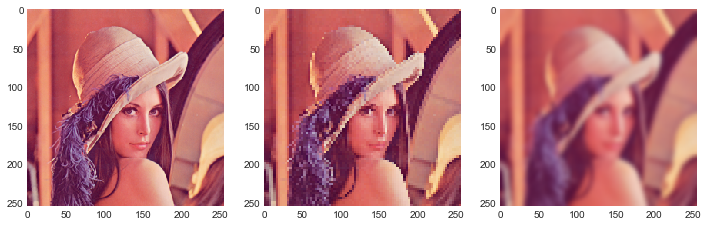

In [13]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax1.imshow(rgb_array)
ax2.imshow(rgb_blockiness_img)
ax3.imshow(rgb_blur_img)
plt.show()

グレースケール画像のときと同様に、いくつかノイズを含ませたカラー画像を用意しました。
ただYUVの3つの値を持つカラー画像に対してPSNRはどのように計算すればよいでしょうか？

考え方は単純です。まず各成分のPSNRスコアを計算し、それぞれ 「PSNRY」「PSNRCb」「PSNRCr」と呼びます。
そしてカラー画像の場合のPSNRスコアは、これらの平均値が広く利用されています。

In [14]:
psnry = psnr(yuv_array[:, :, 0], yuv_blockiness_array[:, :, 0])
psnrcb = psnr(yuv_array[:, :, 1], yuv_blockiness_array[:, :, 1])
psnrcr = psnr(yuv_array[:, :, 2], yuv_blockiness_array[:, :, 2])
print(f"ブロックノイズsの画像との比較: PSNRY={psnry:.02f}, PSNRCb={psnrcb:.02f}, PSNRCr={psnrcr:.02f}, PSNR={np.mean([psnry, psnrcb, psnrcr]):.02f}")

psnry = psnr(yuv_array[:, :, 0], yuv_blur_array[:, :, 0])
psnrcb = psnr(yuv_array[:, :, 1], yuv_blur_array[:, :, 1])
psnrcr = psnr(yuv_array[:, :, 2], yuv_blur_array[:, :, 2])
print(f"ガウシアンブラーノイズの入った画像との比較: PSNRY={psnry:.02f}, PSNRCb={psnrcb:.02f}, PSNRCr={psnrcr:.02f}, PSNR={np.mean([psnry, psnrcb, psnrcr]):.02f}")

ブロックノイズsの画像との比較: PSNRY=24.23, PSNRCb=36.62, PSNRCr=36.47, PSNR=32.44
ガウシアンブラーノイズの入った画像との比較: PSNRY=23.18, PSNRCb=35.85, PSNRCr=35.83, PSNR=31.62


## 人間の知覚品質との差異

MSE/PSNR は単純な画像の変化量を見るのに統計量として適しているため現在でも広く利用されていますが、人間の知覚する品質とは一致しないことが知られています。人間の知覚とPSNRスコアが一致しない例を見てみましょう。

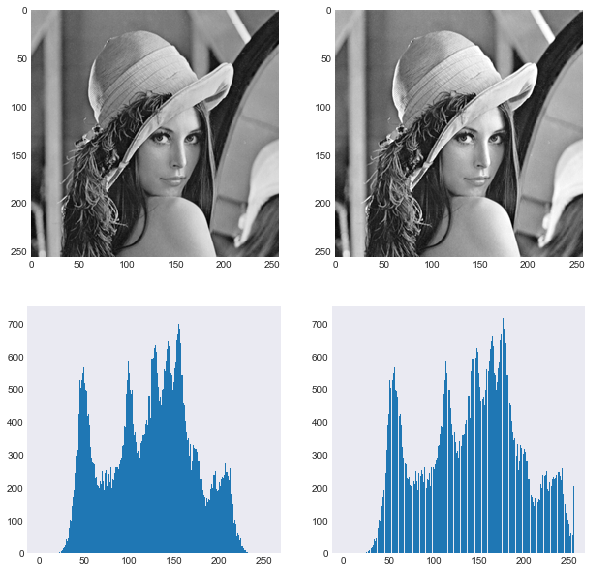

In [15]:
grayscale_luminous_array = np.clip(grayscale_array * 1.15, 0, 255)
grayscale_luminous_img = Image.fromarray(np.uint8(grayscale_luminous_array))

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.imshow(grayscale_array, cmap='gray')
ax2.imshow(grayscale_luminous_array, cmap='gray')
ax3.bar(np.linspace(0, 255, 256), grayscale_img.histogram(), width=1)
ax4.bar(np.linspace(0, 255, 256), grayscale_luminous_img.histogram(), width=1)
plt.show()

各ピクセルの値を全て1.2倍にしました。ヒストグラム中には画像内に存在しない値がでて白線がいくつか入っていますが、全体的に輝度を挙げるだけでは人の目にはあまり違和感はありません。PSNRのスコアを見てみましょう。

In [16]:
psnr(grayscale_array, grayscale_luminous_array)

22.178235207753193

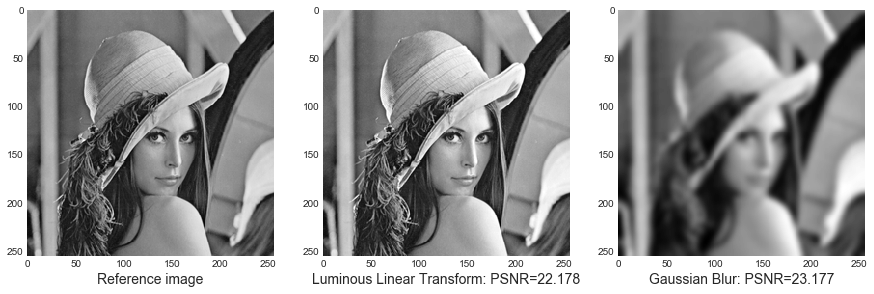

In [17]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax1.imshow(grayscale_array, cmap='gray')
ax1.set_xlabel("Reference image", fontsize=14)
ax2.imshow(grayscale_luminous_array, cmap='gray')
ax2.set_xlabel(f"Luminous Linear Transform: PSNR={psnr(grayscale_array, grayscale_luminous_array):.03f}", fontsize=14)
ax3.imshow(grayscale_blur_array, cmap='gray')
ax3.set_xlabel(f"Gaussian Blur: PSNR={psnr(grayscale_array, grayscale_blur_array):.03f}", fontsize=14)
plt.show()

ガウシアンブラーをかけた値よりも、人間の目には綺麗に見えますが、PSNRの値は下がってしまっています。
他にもPSNRの値が人間の知覚品質と一致しないケースは多くあります。もう少し見てみたい方は、 [MSE/PSNR vs SSIM の比較画像紹介](https://qiita.com/yoya/items/510043d836c9f2f0fe2f) がおすすめです。

## まとめ

今回はディジタル画像の表現とPSNRについて解説しました。次は SSIM と呼ばれる、人間の知覚品質に近づけた指標について解説していきます。

## 用語

- MSE: 平均二乗誤差 (Mean Squared Error)
- PSNR: ピーク信号対ノイズ比 (Peak signal-to-noise ratio)
- HVS: 人間の視覚システム (Human Visual System)
- YUV: 色を輝度信号、青の色差、赤の色差の3つで表現する。色差の変化を捉えるのが苦手なHVSの特性を利用して、色成分のサンプリング間隔を減らすことができる。別名、YCbCr。
- ダイナミックレンジ: 識別可能な信号の範囲
- 色深度: 1ピクセルが表現できる色数